In [1]:
import os
import time
import numpy as np

from PIL import Image
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch import nn
from torchvision import transforms
from torchvision.transforms.functional import resize

import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: parameterized. Use `wandb login --relogin` to force relogin


True

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['image.cmap'] = 'binary'
sns.set_theme(style='darkgrid')

def load_video(path, loop=True):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return display.HTML(f'''<video src="{
        data_url}" controls=true autoplay=true {
        "loop=true " if loop else ""}/>''')

eps = 1e-5

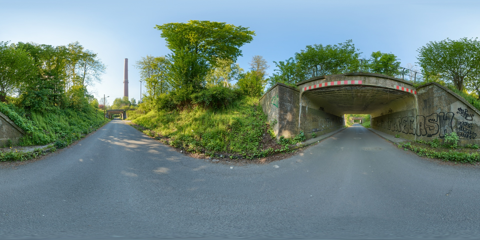

(240, 480, 3)


In [4]:
img = Image.open("panorama_resized.jpg").resize(
    (1920 // 4, 960 // 4))
display.display(img)
img = np.array(img)
print(img.shape)

In [5]:
y_full = torch.tensor(img, device='cuda').permute(2, 0, 1) / 255.
def get_patches(y_full, batch_size, h, w):
    area = h * w / np.prod(y_full.shape[-2:])
    rrc = transforms.RandomResizedCrop((h, w),
        scale=(area, area), ratio=(1, 1))
    return torch.stack([rrc(v) for v in y_full[None].expand(
        batch_size, -1, -1, -1)])

In [6]:
data_mean = y_full.mean(axis=[1, 2]).cpu().numpy()
data_std = y_full.std(axis=[1, 2]).cpu().numpy()
print(data_mean, data_std)

# norm and inverse norm transformations
norm_t = transforms.Normalize(data_mean, data_std)
invnorm_t = transforms.Normalize(-data_mean / data_std, 1 / data_std)

tensor_to_img = lambda x: invnorm_t(x).clip(0, 1).permute(1, 2, 0).detach().cpu()
cropx = lambda x, i=1: x[..., i:-i, i:-i]

[0.4344945  0.5202826  0.49413258] [0.17458405 0.1895633  0.28779888]


In [7]:
embed_channels = 32 # divisible by 2

class Pool():
    def __init__(self, pool_size, cell_channels, patch_size=32, n_levels=4):
        self.size = pool_size
        self.cell_channels = cell_channels
        self.patch_size = patch_size
        self.n_levels = n_levels
        
        self.ts = torch.empty(pool_size, device='cuda')
        self.t_embs = torch.empty(pool_size, embed_channels, device='cuda')        
        
        self.ns = []
        self.x0s = []
        self.xts = []
        ps = patch_size
        for i in range(n_levels):
            self.ns.append(torch.empty(
                pool_size, cell_channels, ps, ps, device='cuda'))
            self.x0s.append(torch.empty(
                pool_size, 3, ps, ps, device='cuda'))
            self.xts.append(torch.empty(
                pool_size, cell_channels, ps, ps, device='cuda'))
            ps //= 2
        
        self.init()
    
    def init(self, indices=None, ts=None):
        """
        Initialize the pool, optionally only at given indices
        or with given ts (1D tensor with same length as indices)
        """
        if indices is None:
            indices = torch.arange(self.size)
        if ts is None:
            ts = torch.rand(len(indices), device='cuda')
        
        self.ts[indices] = ts
        self.t_embs[indices] = self.embed_ts(ts)
        
        # init highest res maps
        self.ns[0][indices] = torch.randn_like(self.ns[0][indices])
        ps = self.patch_size
        rgb = get_patches(y_full, len(indices), ps, ps)
        self.x0s[0][indices] = norm_t(rgb)
        self.xts[0][indices] = torch.randn_like(self.xts[0][indices])
        self.xts[0][indices, :3] = self.x0s[0][indices].clone()
        self.xts[0][indices] = torch.lerp(
            self.xts[0][indices], self.ns[0][indices], ts[:, None, None, None])
        
        # downscale to init the rest
        for i in range(1, self.n_levels):
            for v in [self.ns, self.x0s, self.xts]:
                v[i] = resize(v[i-1], v[i].shape[-1])
    
    def init_keep_feats(self, indices):
        """
        Initialize at given indices but keep non-rgb features
        """
        prev_xts = [v[indices].detach().clone() for v in self.xts]
        self.init(indices)
        for i, xt in enumerate(self.xts):
            xt[indices, 3:] = prev_xts[i][:, 3:]
    
    def sample(self, indices):
        return [v[indices] for v in [self.ts, self.t_embs]
            ] + [[v[indices] for v in m]
                for m in [self.ns, self.x0s, self.xts]]
    
    def clone(self):
        p2 = Pool(self.size, self.cell_channels, self.patch_size, self.n_levels)
        p2.ts = self.ts.detach().clone()
        p2.t_embs = self.t_embs.detach().clone()
        for i, (n, xt, x0) in enumerate(
                zip(self.ns, self.xts, self.x0s)):
            p2.ns[i] = n.detach().clone()
            p2.x0s[i] = x0.detach().clone()
            p2.xts[i] = xt.detach().clone()
        
        return p2
    
    def embed_ts(self, t, n_freqs=embed_channels // 2):
        emb = t[:, None] * 2**torch.arange(n_freqs, device='cuda') * torch.pi / 2
        return torch.cat([emb.sin(), emb.cos()], dim=-1)

In [8]:
cell_channels = 32
hidden_feats = 128

class LayerNorm(nn.Module):
    def forward(self, x):
        var, mean = torch.var_mean(x, dim=1,
            unbiased=False, keepdim=True)
        return (x - mean) * (var + eps).rsqrt()
        

class FractalDN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(cell_channels * 3, hidden_feats, 3,
                            padding=1, padding_mode='replicate')
        self.l2 = nn.Conv2d(hidden_feats, cell_channels, 1)
        
        self.scale_shift_l1 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embed_channels, hidden_feats * 2))
        self.scale_shift_l2 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embed_channels, cell_channels * 2))
        
        self.layer_norm = LayerNorm()
        
        nn.init.zeros_(self.l2.weight)
        nn.init.zeros_(self.l2.bias)
    
    def forward(self, bts, btes, bxts):
        """
        Evaluate the model
        
        Args:
            bts, btes, bxts: Lists of tensors
                with resolution decreasing by half (e.g. 32, 16, 8).
                bts - batch t tensors
                btes - batch t embedding tensors
                bxts - batch x_t tensors
        
        Returns:
            A list of predicted x_0 + feature tensors
        """
        preds = []
        ss_l1 = self.scale_shift_l1(btes)
        ss_l2 = self.scale_shift_l2(btes)
        for i, bxt in enumerate(bxts):
            # higher res, lower res
            hr = bxt if i == 0 else resize(bxts[i - 1], bxt.shape[-1])
            lr = bxt if i == len(bxts) - 1 else resize(
                bxts[i + 1], bxt.shape[-1])
            xin = torch.cat([hr, bxt, lr], dim=1)
            
            h = self.l1(xin).relu()
            h = self.layer_norm(h) * ss_l1[:, :hidden_feats, None, None]
            h = h + ss_l1[:, hidden_feats:, None, None]
            
            h = self.l2(h)
            h = self.layer_norm(h) * ss_l2[:, :cell_channels, None, None]
            py = h + ss_l2[:, cell_channels:, None, None]
            
            preds.append(bxt + py)
            
            # multiply rgb predicted change by t, rest are free
            # also clip to prevent explosion
            # preds.append(torch.cat([
            #     bxt[:, :3] + py[:, :3] * bts[:, None, None, None],
            #     bxt[:, 3:] + py[:, 3:]], dim=1).clip(-3, 3))
            # multiply all by t
            # preds.append((bxt + self.l2(h) * bts[:, None, None, None]).clip(-3, 3))
        
        return preds

model = FractalDN().cuda()

opt = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt,
    lambda epoch: max(0.95**epoch, 0.1))
loss_fn = nn.MSELoss()
losses = []

batch_size = 64
diffusion_steps = 48

pool = Pool(pool_size=batch_size*8, cell_channels=cell_channels)

10,000 / 10,000
42m - eta 0s
lr: 0.00018868
loss: 0.10249672


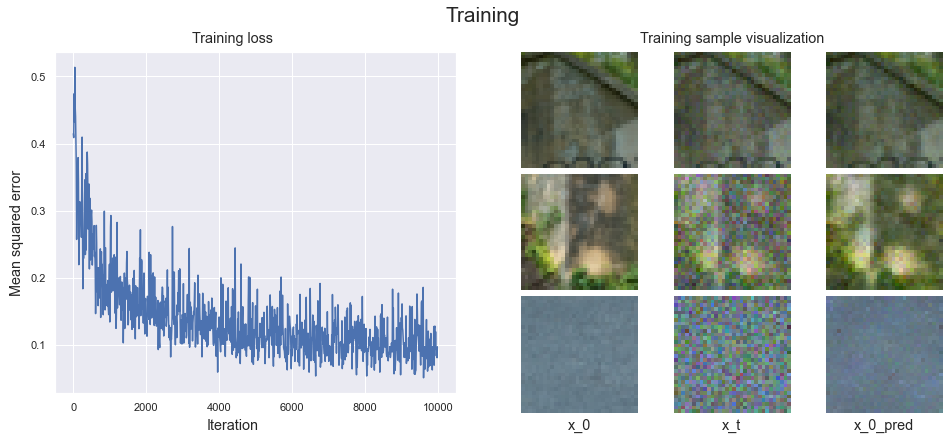

Saved to models/FractalDN_467194360.pt


train/loss,█▆▅▄▆▃▃▄▂▂▂▂▂▁▂▂▂▁▁▂▂▂▂▁▂▃▁▂▃▂▁▁▂▁▁▁▁▃▁▂
train/step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,0.09747
train/step,9999


In [9]:
model_id = f'{np.random.randint(1e9):09d}'

run = wandb.init(
    mode='disabled',
    project='FractalDN',
    config={
        'model_id': model_id,
        'cell_channels': cell_channels
    },
    save_code=True)
wandb.define_metric('train/step')
wandb.define_metric('train/*', step_metric='train/step')

with run:
    print('Training...')
    train_st = time.time()
    time_to_s = lambda t: f'{int(t)}s' if t < 60 else f'{int(t / 60)}m'

    train_iters = int(1e4)
    inner_iters = 4

    loss_every_n = 10
    display_every_n = 100
    scheduler_every_n = 500

    for i in range(train_iters):
        # sample from pool
        perm = torch.randperm(pool.size)[:batch_size]
        # replace 1/4 of batch with new samples
        pool.init(perm[:batch_size // 4])
        # replace next 1/4 but keep non-rgb features
        pool.init_keep_feats(perm[batch_size // 4 : batch_size // 2])
        # replace whole batch
        # pool.init(perm)

        [bts, btes, bns, bx0s, bxts] = pool.sample(perm)

        # predict x_0
        for j in range(inner_iters):
            x0_preds = model(bts, btes, bxts)
            # only update non-rgb features
            bxts = [torch.cat([xt[:, :3], x0p[:, 3:]], dim=1)
                    for xt, x0p in zip(bxts, x0_preds)]

        # opt step
        loss = torch.cat([loss_fn(x0p[:, :3], bx0)[None]
                          for x0p, bx0 in zip(x0_preds, bx0s)]).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()

        # update pool
        for j, bxt in enumerate(bxts):
            pool.xts[j][perm] = bxt.detach().clone()

        # plot
        if (i + 1) % loss_every_n == 0:
            losses.append(loss.item())
            wandb.log({
                'train/step': i + 1,
                'train/loss': loss.item()
            })
        if (i + 1) % display_every_n == 0:
            display.clear_output(wait=True)
            print(f'{i + 1 :,} / {train_iters:,}')
            time_passed = time.time() - train_st
            eta = time_passed * (train_iters - i) / max(i, 1)
            print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
            print(f'lr: {opt.state_dict()["param_groups"][0]["lr"]:.8f}')
            print(f'loss: {np.mean(losses[-100:]):.8f}')

            fig = plt.figure(constrained_layout=True, figsize=(6 * 2.2, 6))
            fig.suptitle('Training', fontsize='xx-large')
            [loss_fig, vis_fig] = fig.subfigures(1, 2, wspace=.1)

            loss_fig.suptitle('Training loss')
            loss_fig.supxlabel('Iteration')
            loss_fig.supylabel('Mean squared error')

            vis_fig.suptitle('Training sample visualization')

            ax = loss_fig.gca()
            sns.lineplot(np.arange(len(losses)) * loss_every_n, losses, ax=ax)

            vis_col_figs = vis_fig.subfigures(1, 3)
            [x0_axes, xt_axes, x0p_axes] = [
                v.subplots(3, 1) for v in vis_col_figs]
            for f, label in zip(vis_col_figs, ['x_0', 'x_t', 'x_0_pred']):
                f.supxlabel(label)

            for k in range(3):
                x0_axes[k].imshow(tensor_to_img(bx0s[0][k]))
                x0_axes[k].axis('off')
                xt_axes[k].imshow(tensor_to_img(bxts[0][k, :3]))
                xt_axes[k].axis('off')
                x0p_axes[k].imshow(tensor_to_img(x0_preds[0][k, :3]))
                x0p_axes[k].axis('off')

            plt.show()
        if (i + 1) % scheduler_every_n == 0:
            scheduler.step()
    
    model_path = f'models/FractalDN_{model_id}.pt'
    torch.save(model, model_path)
    print(f'Saved to {model_path}')

In [11]:
from tqdm import tqdm
tqdm._instances.clear()

def gen_sampling_video(path, duration=2, fps=24):
    vid_pool = Pool(pool_size=8, cell_channels=cell_channels, patch_size=32)
    vid_pool.init(ts=torch.ones(8, device='cuda'))
    perm = torch.arange(8)
    def make_frame(t):
        t = 1 - t / duration - 1 / (duration * fps)
        # only using/replacing bxts in pool
        [_bts, _btes, _bns, _bx0s, bxts] = vid_pool.sample(perm)
        # reset non-rgb features - temporary solution for better adaptivity
        bxts = [torch.cat([xt[:, :3], torch.randn_like(xt[:, 3:])], dim=1)
                for xt in bxts]
        with torch.no_grad():
            # predict x_0
            bts = torch.full((8,), t, device='cuda')
            btes = vid_pool.embed_ts(bts)
            
            for i in range(8):
                x0_preds = model(bts, btes, bxts)
                # only update non-rgb features
                bxts = [torch.cat([xt[:, :3], x0p[:, 3:]], dim=1)
                        for xt, x0p in zip(bxts, x0_preds)]
            
            # reverse diffusion step
            # bxts = [torch.lerp(x0p, n, t)
            #         for x0p, n, t in zip(x0_preds, bns, bts)]
            lerp_ts = [(1 / diffusion_steps / (t + eps)).clip(0, 1)
                       for t in bts]
            bxts = [torch.lerp(xt, x0p, lt)
                    for xt, x0p, lt in zip(bxts, x0_preds, lerp_ts)]
            
            # update pool
            for i, bxt in enumerate(bxts):
                vid_pool.xts[i][perm] = bxt.detach().clone()
            
            # make image grid
            xt_imgs = [*map(tensor_to_img, bxts[0][:, :3])]
            x0p_imgs = [*map(tensor_to_img, x0_preds[0][:, :3])]
            cols = [torch.cat(v, dim=0) for v in [
                xt_imgs[:4],
                x0p_imgs[:4],
                xt_imgs[4:],
                x0p_imgs[4:]
            ]]
            img = torch.cat(cols, dim=1)
        img = resize(img.permute(2, 0, 1), 512).permute(1, 2, 0)
        return img.detach().clone().clip(0, 1).multiply(255).int().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    # 1st is for changing xt, 2nd for original noise
    clip = mpy.VideoClip(lambda t: make_frame(t), duration=duration)
    clip.write_videofile(path, fps=fps)
    return clip

clip = gen_sampling_video('output/fractal_dn.mp4')
display.display(load_video('output/fractal_dn.mp4', loop=False))

Moviepy - Building video output/fractal_dn.mp4.
Moviepy - Writing video output/fractal_dn.mp4



Moviepy - Done !
Moviepy - video ready output/fractal_dn.mp4


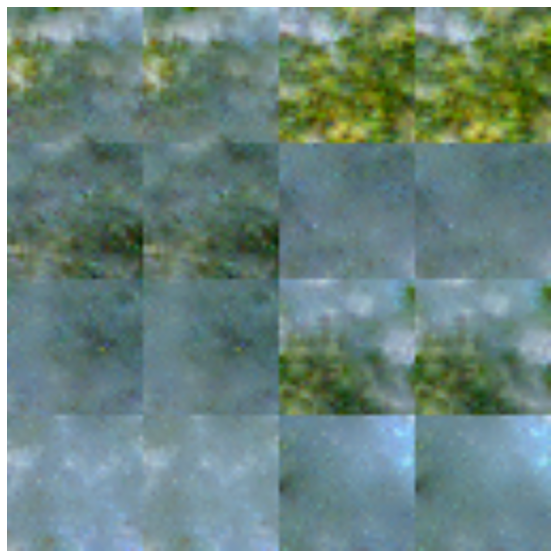

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(clip.get_frame(2) / 255)
plt.axis('off')
plt.show()